In [1]:
%reload_ext autoreload
%autoreload 2

In [24]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tomllib
from stable_baselines3 import SAC

from baselines.twap_vwap import twap_schedule
from baselines.almgren_chriss import almgren_chriss_linear
from baselines.bh_mom_rev import equal_weight, momentum_signal
from envs.alloc_env import AllocationEnv
from eval.metrics import sharpe, max_drawdown
from utils.data import load_prices_yf

### Load data & model

In [17]:
MODELS_DIR = Path(os.getenv('MODELS_DIR', './lab/rl/models'))
CONFIGS_DIR = Path(os.getenv('CONFIGS_DIR', './lab/rl/experiments'))

cfg = tomllib.load((CONFIGS_DIR / 'alloc_risk_reward.toml').open('rb'))['data']

# print(cfg)
prices = load_prices_yf(cfg)
env = AllocationEnv(prices)
model = SAC.load(MODELS_DIR / 'alloc_sac_final.zip')

### Evaluate RL vs. baselines

In [19]:
obs, _ = env.reset()
done = False
eq_rl = [1.0]
rets = []
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, r, done, _, _ = env.step(action)
    eq_rl.append(eq_rl[-1]*np.exp(r))
    rets.append(r)

### Baseline: equal-weight

In [20]:
eq_ew = [1.0]
for r in env.returns:
    eq_ew.append(eq_ew[-1]*np.exp(r @ equal_weight(env.N)))

### Plot

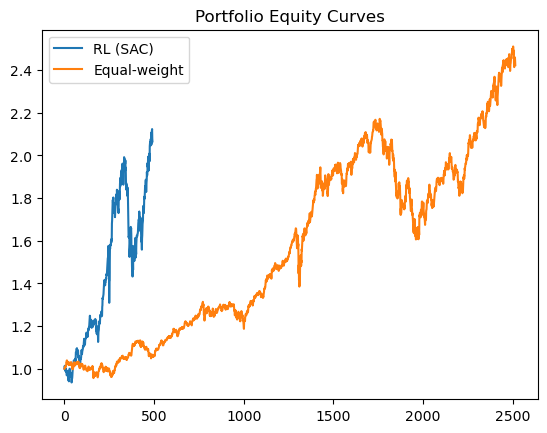

In [22]:
plt.plot(eq_rl, label="RL (SAC)")
plt.plot(eq_ew, label="Equal-weight")
plt.title("Portfolio Equity Curves")
plt.legend()
plt.show()

### Metrics

In [25]:
print("RL Sharpe:", sharpe(rets))
print("RL MaxDD:", max_drawdown(eq_rl))

RL Sharpe: 0.09276414279499581
RL MaxDD: -0.2810308367500679
